# Dataloading

In [1]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import numpy as np

TRAIN_DIR = "/home/undergrad/2026/wcarvalh/Documents/spring-2025/chm/hw4/data/TRAIN_NEW"
# Load the connectome CSV file without the first column (which contains patient IDs)
connectome_df_no_labels = pd.read_csv(TRAIN_DIR + '/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv', index_col=0)

categorical_df = pd.read_excel(TRAIN_DIR + "/TRAIN_CATEGORICAL_METADATA_new.xlsx")
solutions_df = pd.read_excel(TRAIN_DIR + "/TRAINING_SOLUTIONS.xlsx")


# Preprocessing
## GNN Baseline

In [2]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GCNConv, EdgeConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("CUDA device count:", torch.cuda.device_count())
    print("CUDA version (from torch):", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())


device: cuda
GPU name: NVIDIA RTX 6000 Ada Generation
CUDA device count: 8
CUDA version (from torch): 12.1
cuDNN version: 8907


In [3]:

# get the number of patients and the length of the vector for each patient
num_patients = connectome_df_no_labels.shape[0]
vector_length = connectome_df_no_labels.shape[1]

# reconstruct the matrix size from the vector length
n = int((1 + math.sqrt(1 + 8 * vector_length)) / 2)  # should be 200

# initialize a 3d numpy array to store all matrices
connectome_array = np.zeros((num_patients, n, n))

# fill the array with each patient's full matrix
for patient_index in range(num_patients):
    patient_vector = connectome_df_no_labels.iloc[patient_index].values

    matrix = np.zeros((n, n))
    lower_indices = np.tril_indices(n, k=-1)
    matrix[lower_indices] = patient_vector
    matrix = matrix + matrix.T  # make it symmetric
    np.fill_diagonal(matrix, 1)  # set diagonal to 1

    connectome_array[patient_index] = matrix

# convert our data to torch tensors
connectivity_matrices = torch.tensor(connectome_array).float()
labels_sex = torch.tensor(solutions_df['Sex_F']).float()
labels_diagnosis = torch.tensor(solutions_df['ADHD_Outcome']).float()

# stack the target variable labels
labels = torch.stack([labels_diagnosis, labels_sex],dim=1)

# create graph data objects for each matrix
data_list = []
for i in range(len(connectivity_matrices)):
    matrix = connectivity_matrices[i]
    #edge_index = (matrix > 0).nonzero(as_tuple=False).t() # create edges based on non-zero entries
    #edge_attr = matrix[edge_index[0], edge_index[1]] # edge weights are the matrix values
    k = 15  # or 15, depending on how sparse you want the graph

    # list to collect top-k edges
    edges = []
    weights = []

    for node in range(n):
        # get connection strengths to all other nodes
        connections = matrix[node]

        # exclude self-connections
        connections[node] = -float("inf")

        # get top-k indices
        topk_indices = torch.topk(connections.abs(), k=k).indices

        for target in topk_indices:
            edges.append([node, target.item()])
            weights.append(matrix[node, target].item())

    # convert to edge_index and edge_attr
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()  # shape [2, num_edges]
    edge_attr = torch.tensor(weights, dtype=torch.float)  # shape [num_edges]

    x = torch.eye(200) # node features (identity matrix as features)
 
    # create graph data object
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=labels_diagnosis[i].unsqueeze(0))
    data_list.append(graph_data)
    #print(graph_data)
torch.manual_seed(192024)


## Model Development

In [4]:
# defining the model
class GCN(torch.nn.Module):
    def __init__(self, in_channels=200, hidden_channels=64, num_classes=1):
        super(GCN, self).__init__()
        # shared mlp used in all EdgeConv layers
        self.edge_mlp1 = Sequential(Linear(2 * in_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.edge_mlp2 = Sequential(Linear(2 * hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.edge_mlp3 = Sequential(Linear(2 * hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.edge_mlp4 = Sequential(Linear(2 * hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.edge_mlp5 = Sequential(Linear(2 * hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))

        self.conv1 = EdgeConv(nn=self.edge_mlp1)
        self.conv2 = EdgeConv(nn=self.edge_mlp2)
        self.conv3 = EdgeConv(nn=self.edge_mlp3)
        self.conv4 = EdgeConv(nn=self.edge_mlp4)
        self.conv5 = EdgeConv(nn=self.edge_mlp5)

        self.lin = Linear(hidden_channels, num_classes)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x1 = self.conv1(x, edge_index)
        x2 = self.conv2(x1, edge_index) + x1  # skip connection
        x3 = self.conv3(x2, edge_index) + x2
        x4 = self.conv4(x3, edge_index) + x3
        x5 = self.conv5(x4, edge_index) + x4
        
        x_pool = global_mean_pool(x5, batch)

        out = self.lin(x_pool).squeeze(1)
        #print("out", out)
        #print(x_pool.view(-1))
        #return x_pool.view(-1) # ensuring output has the correct shape (batch_size,)
        return out

## Data Splitting and Model Training
### Target Variable #1: ADHD Diagnosis

In [5]:
def train(train_loader):
    model.train()
    total_loss = 0
    for data in train_loader: # load batches from data loader
        optimizer.zero_grad() # reset gradients
        data.to(device)
        
        out = model(data) # pass batch thru model to obtain predictions (forward pass)
        loss = criterion(out, data.y) # calculate loss between predictions and true labels
        loss.backward() # backpropagate the loss to compute gradients
        optimizer.step() # update the model's parameters using the gradients
        total_loss += loss.item() # accumulate batch loss into total loss
    return total_loss / len(train_loader)

def evaluate_model(model, data_loader):
    model.eval()
    actual_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for data in data_loader:
            data.to(device)
            
            out = model(data)                # shape: [batch_size,]
            preds = torch.sigmoid(out)       # get probabilities
            predicted_labels.append(preds.cpu())
            actual_labels.append(data.y.cpu()) # true labels

    # concat into full tensors
    actual_labels = torch.cat(actual_labels, dim=0)
    predicted_labels = torch.cat(predicted_labels, dim=0)
    #print(predicted_labels)
    # binarize predictions using threshold 0.5
    bin_preds = (predicted_labels >= 0.5).int()

    return actual_labels.numpy(), bin_preds.numpy(), predicted_labels.numpy()

In [6]:
# apply a data split here: training --> training/validation, test
labels_arr = labels_diagnosis.numpy() 
X_trainval, X_test, y_trainval, y_test = train_test_split(data_list, labels_arr, test_size=0.2, random_state=42)

# resample training data to handle class imbalance
indices = np.arange(len(y_trainval)).reshape(-1, 1)
ros = RandomOverSampler(random_state=0)
indices_resampled, y_trainval = ros.fit_resample(indices, y_trainval)
X_trainval = [X_trainval[i] for i in indices_resampled.flatten()]

In [7]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gnn_scores = []
y_preds = []
y_vals = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    # split data
    train_data = [X_trainval[i] for i in train_idx]
    val_data = [X_trainval[i] for i in val_idx]
    y_val = y_trainval[val_idx]

    # data loaders
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

    # training the model
    model = GCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # set up optimizer
    criterion = torch.nn.BCEWithLogitsLoss() # define criterion

    # train the model for a number of epochs
    losses = []
    for epoch in range(70):
        loss = train(train_loader)
        losses.append(loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')
            
    epochs =list(range(1, len(losses) + 1))

    # evaluate on validation set
    y_true, y_pred, y_probs = evaluate_model(model, val_loader)
    f1 = f1_score(y_true, y_pred, average="macro")
    gnn_scores.append(f1)
    y_preds.extend(y_pred)
    y_vals.extend(y_val)

/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.7020
Epoch 10, Loss: 0.7576
Epoch 20, Loss: 0.6959
Epoch 30, Loss: 0.4360
Epoch 40, Loss: 0.0009
Epoch 50, Loss: 0.0001
Epoch 60, Loss: 0.0000


/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.6998
Epoch 10, Loss: 0.6938
Epoch 20, Loss: 0.7223
Epoch 30, Loss: 0.6297
Epoch 40, Loss: 0.2230
Epoch 50, Loss: 0.1632
Epoch 60, Loss: 0.2331


/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.6986
Epoch 10, Loss: 0.7057
Epoch 20, Loss: 0.6521
Epoch 30, Loss: 0.2445
Epoch 40, Loss: 0.0841
Epoch 50, Loss: 0.0341
Epoch 60, Loss: 0.0146


/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.7018
Epoch 10, Loss: 0.7080
Epoch 20, Loss: 0.9913
Epoch 30, Loss: 0.1555
Epoch 40, Loss: 0.0002
Epoch 50, Loss: 0.0001
Epoch 60, Loss: 0.0000


/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.6988
Epoch 10, Loss: 0.6974
Epoch 20, Loss: 0.6900
Epoch 30, Loss: 0.3945
Epoch 40, Loss: 0.0489
Epoch 50, Loss: 0.0001
Epoch 60, Loss: 0.0000


### Training Loss

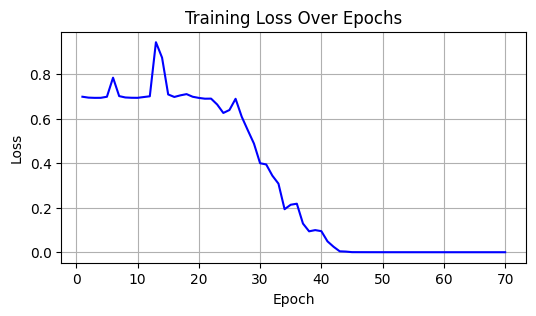

In [8]:
# visualize loss values
plt.figure(figsize=(6, 3))
plt.plot(epochs, losses, linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### F1 Score

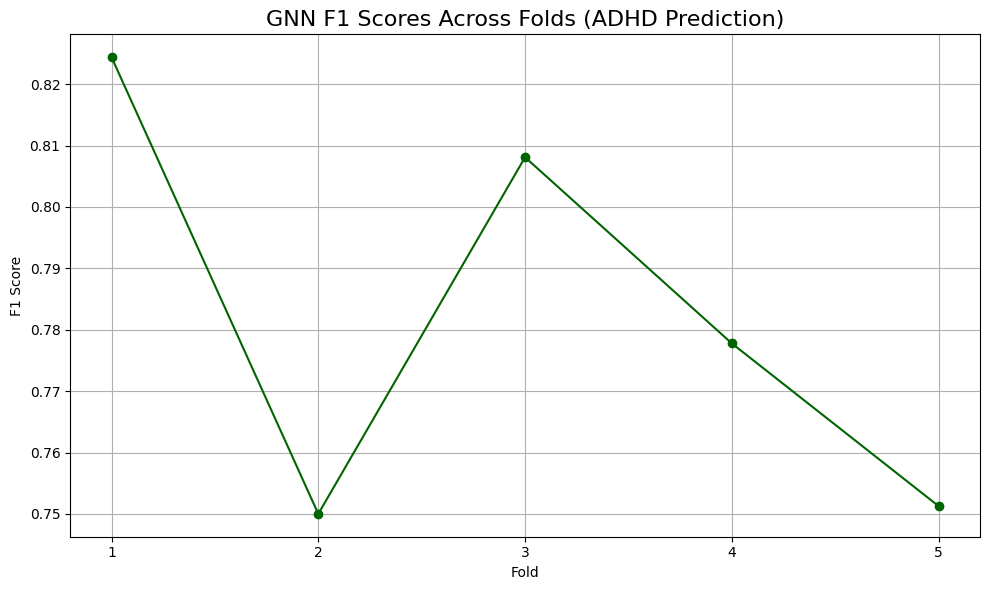

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), gnn_scores, marker='o', linestyle='-', color='darkgreen')
plt.title("GNN F1 Scores Across Folds (ADHD Prediction)", fontsize=16)
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrix

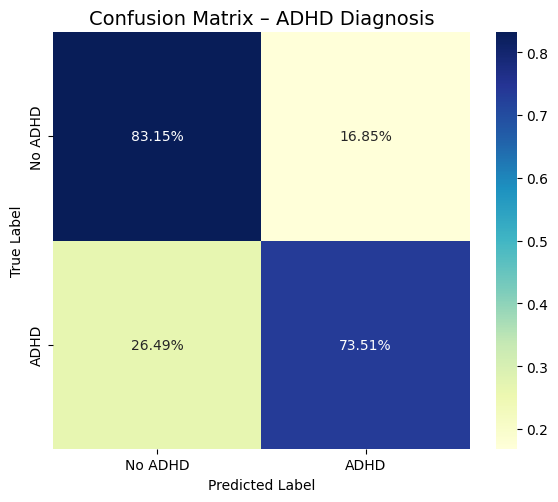

In [10]:
cm = confusion_matrix(y_vals, y_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title(f"Confusion Matrix – ADHD Diagnosis", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0.5, 1.5], ["No ADHD", "ADHD"]) 
plt.yticks([0.5, 1.5], ["No ADHD", "ADHD"]) 

plt.tight_layout()
plt.show()

### Classification Report
Includes accuracy, precision, recall, and F1 Score

In [11]:
print("\nClassification Report (Aggregated Predictions Across Folds):")
print(classification_report(y_vals, y_preds, digits=3))


Classification Report (Aggregated Predictions Across Folds):
              precision    recall  f1-score   support

         0.0      0.758     0.832     0.793       653
         1.0      0.814     0.735     0.772       653

    accuracy                          0.783      1306
   macro avg      0.786     0.783     0.783      1306
weighted avg      0.786     0.783     0.783      1306



# Test Dataset & Metrics

Includes classification report (which includes F1 score, accuracy, precision, and recall) and confusion matrix.

Test Accuracy: 0.568
Test F1 Score: 0.685

Classification Report:
              precision    recall  f1-score   support

         0.0      0.273     0.369     0.314        65
         1.0      0.735     0.640     0.685       178

    accuracy                          0.568       243
   macro avg      0.504     0.505     0.499       243
weighted avg      0.612     0.568     0.585       243



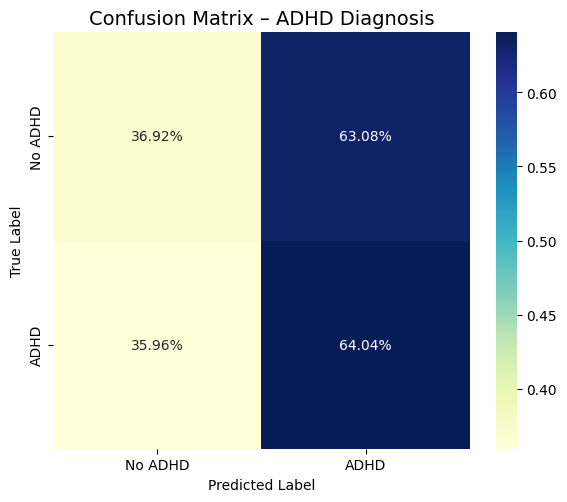

In [12]:
# -----------------------------
# this section was just modified from above
# evaluate model on test data
# -----------------------------

# import missing sklearn metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# define test_loader
test_loader = DataLoader(X_test, batch_size=8, shuffle=False)

# run predictions
y_true, y_pred, y_probs = evaluate_model(model, test_loader)

# calculate performance metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
#precision = precision_score(y_true, y_pred)
#recall = recall_score(y_true, y_pred)

# print results
print("Test Accuracy:", round(acc, 3))
print("Test F1 Score:", round(f1, 3))
#print("Precision:", round(precision, 3))
#print("Recall:", round(recall, 3))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))

# normalized confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title("Confusion Matrix – ADHD Diagnosis", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ["No ADHD", "ADHD"])
plt.yticks([0.5, 1.5], ["No ADHD", "ADHD"])
plt.tight_layout()
plt.show()


### Improving the model: Implementing Class Weighting in Loss

/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 - Train Loss: 0.0000 | Val Loss: 2.0273
Epoch 2 - Train Loss: 0.0000 | Val Loss: 2.0457
Epoch 3 - Train Loss: 0.0000 | Val Loss: 2.0722
Epoch 4 - Train Loss: 0.0000 | Val Loss: 2.0940
Epoch 5 - Train Loss: 0.0000 | Val Loss: 2.1268
Epoch 6 - Train Loss: 0.0000 | Val Loss: 2.1423
early stopping at epoch 6
Test Accuracy: 0.564
Test F1 Score: 0.679
Precision: 0.737
Recall: 0.629

Classification Report:
              precision    recall  f1-score   support

         0.0      0.275     0.385     0.321        65
         1.0      0.737     0.629     0.679       178

    accuracy                          0.564       243
   macro avg      0.506     0.507     0.500       243
weighted avg      0.613     0.564     0.583       243



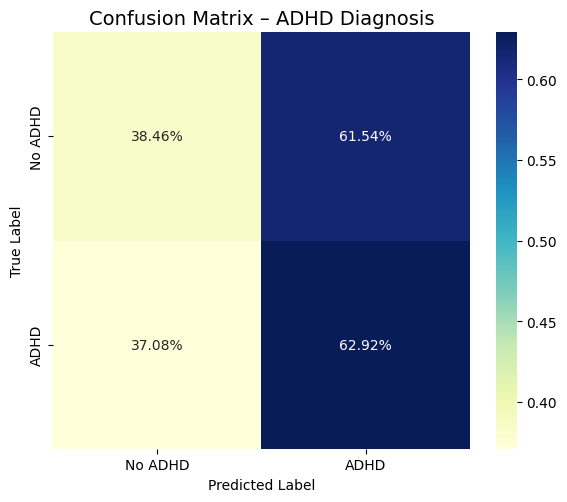

precision (non-adhd): 0.27472527472527475
recall (non-adhd): 0.38461538461538464
precision (adhd): 0.7368421052631579
recall (adhd): 0.6292134831460674


In [13]:
# -----------------------
# 1. implement class weighting in loss
# -----------------------

# calculate ratio of adhd vs non-adhd to balance the loss function
adhd_ratio = (labels_diagnosis == 1).float().mean().item()
non_adhd_ratio = 1.0 - adhd_ratio

# set pos_weight to give more attention to the non-adhd class
pos_weight = torch.tensor(non_adhd_ratio / adhd_ratio)

# use binary cross entropy with logits and class weights
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


# -----------------------
# 2. update your GCN class with dropout
# -----------------------

# inside your GCN class definition, make sure you add this to __init__:
# self.dropout = torch.nn.Dropout(0.3)

# then in the forward method, apply dropout after final conv like this:
# x5 = self.dropout(self.conv5(x4, edge_index) + x4)


# -----------------------
# 3. define a helper to compute validation loss
# -----------------------

def evaluate_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in data_loader:
            data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(data_loader)


# -----------------------
# 4. early stopping during training
# -----------------------

# number of training epochs
num_epochs = 50  # set how long you want to train for

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader)
    val_loss = evaluate_loss(model, val_loader)

    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"early stopping at epoch {epoch}")
            break

# restore best model
model.load_state_dict(best_model_state)

# -----------------------
# 5. evaluate test set predictions and per-class metrics
# -----------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# define test_loader
test_loader = DataLoader(X_test, batch_size=8, shuffle=False)

# run model predictions
y_true, y_pred, y_probs = evaluate_model(model, test_loader)

# compute metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Test Accuracy:", round(acc, 3))
print("Test F1 Score:", round(f1, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))

# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title("Confusion Matrix – ADHD Diagnosis", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ["No ADHD", "ADHD"])
plt.yticks([0.5, 1.5], ["No ADHD", "ADHD"])
plt.tight_layout()
plt.show()

# -----------------------
# 6. evaluate class-wise precision and recall
# -----------------------

print("precision (non-adhd):", precision_score(y_true, y_pred, pos_label=0))
print("recall (non-adhd):", recall_score(y_true, y_pred, pos_label=0))
print("precision (adhd):", precision_score(y_true, y_pred, pos_label=1))
print("recall (adhd):", recall_score(y_true, y_pred, pos_label=1))


# Training Again
### Target Variable #2: Sex Prediction

In [14]:
# apply a data split here: training --> training/validation, test
X_trainval, X_test, y_trainval, y_test = train_test_split(data_list, labels_sex, test_size=0.2, random_state=42)

# resample training data to handle class imbalance
indices = np.arange(len(y_trainval)).reshape(-1, 1)
ros = RandomOverSampler(random_state=0)
indices_resampled, y_trainval = ros.fit_resample(indices, y_trainval)
X_trainval = [X_trainval[i] for i in indices_resampled.flatten()]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gnn_scores = []
y_preds = []
y_vals = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    # split data
    train_data = [X_trainval[i] for i in train_idx]
    val_data = [X_trainval[i] for i in val_idx]
    y_val = y_trainval[val_idx]

    # data loaders
    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

    # training the model
    model = GCN()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # set up optimizer
    criterion = torch.nn.BCEWithLogitsLoss() # define criterion

    # train the model for a number of epochs
    losses = []
    for epoch in range(50):
        loss = train(train_loader)
        losses.append(loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')
            
    epochs =list(range(1, len(losses) + 1))

    # evaluate on validation set
    y_true, y_pred, y_probs = evaluate_model(model, val_loader)
    f1 = f1_score(y_true, y_pred, average="macro")
    gnn_scores.append(f1)
    y_preds.extend(y_pred)
    y_vals.extend(y_val)

/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.6532
Epoch 10, Loss: 0.6448
Epoch 20, Loss: 0.6388
Epoch 30, Loss: 0.6379
Epoch 40, Loss: 0.7293


/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.6607
Epoch 10, Loss: 0.6521
Epoch 20, Loss: 0.6466
Epoch 30, Loss: 0.6396
Epoch 40, Loss: 0.5415


/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.6421
Epoch 10, Loss: 0.6353
Epoch 20, Loss: 0.7227
Epoch 30, Loss: 0.2361
Epoch 40, Loss: 0.4239


/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.6568
Epoch 10, Loss: 0.6471
Epoch 20, Loss: 0.6397
Epoch 30, Loss: 0.6788
Epoch 40, Loss: 0.5005


/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 0, Loss: 0.6501
Epoch 10, Loss: 0.6544
Epoch 20, Loss: 0.8012
Epoch 30, Loss: 0.6216
Epoch 40, Loss: 0.3894


### Training Loss

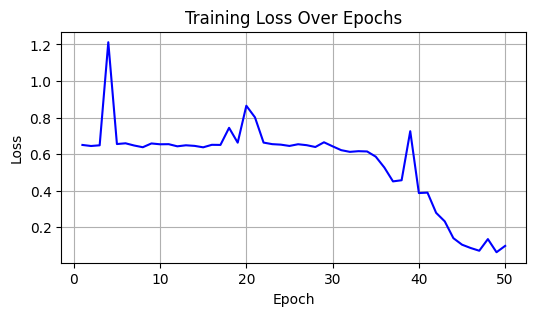

In [15]:
# visualize loss values
plt.figure(figsize=(6, 3))
plt.plot(epochs, losses, linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### F1 Scores

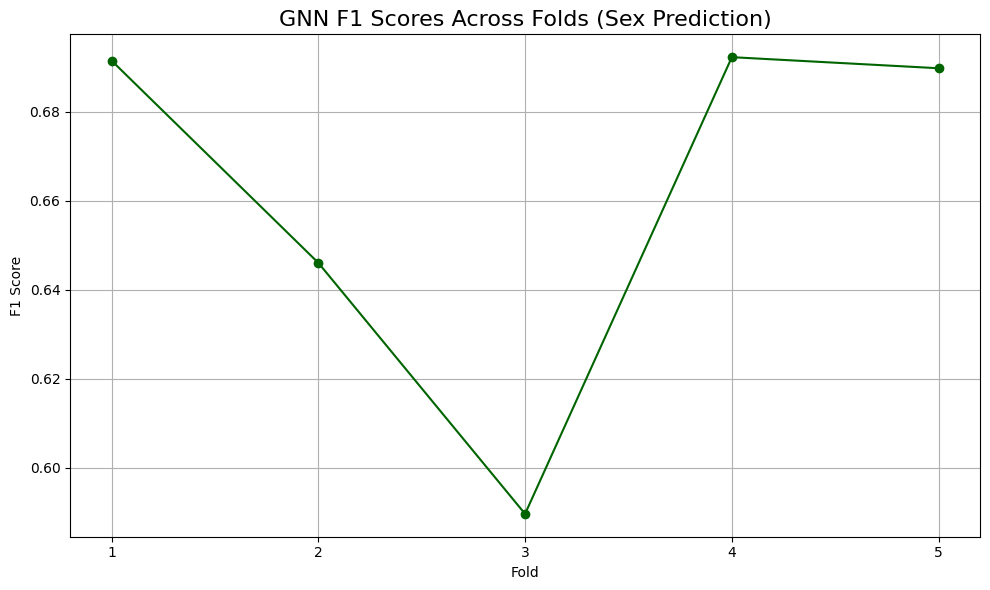

In [16]:
# F1 Scores
#print(gnn_scores)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), gnn_scores, marker='o', linestyle='-', color='darkgreen')
plt.title("GNN F1 Scores Across Folds (Sex Prediction)", fontsize=16)
plt.xlabel("Fold")
plt.ylabel("F1 Score")
plt.xticks(range(1, 6))
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrix

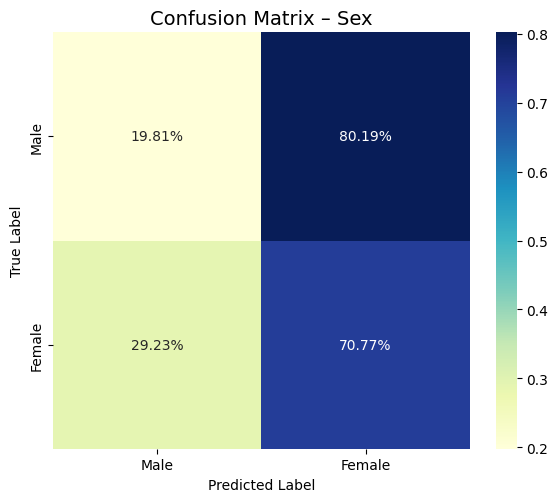

In [17]:
# Confusion Matrix
#print(y_preds)
#print(y_vals)
cm = confusion_matrix(y_vals, y_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title(f"Confusion Matrix – Sex", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks([0.5, 1.5], ["Male", "Female"]) 
plt.yticks([0.5, 1.5], ["Male", "Female"]) 

plt.tight_layout()
plt.show()

### Classification Report
Includes accuracy, precision, recall, and F1 Score

In [18]:
print("\nClassification Report (Aggregated Predictions Across Folds):")
print(classification_report(y_vals, y_preds, digits=3))


Classification Report (Aggregated Predictions Across Folds):
              precision    recall  f1-score   support

         0.0      0.404     0.198     0.266       626
         1.0      0.469     0.708     0.564       626

    accuracy                          0.453      1252
   macro avg      0.436     0.453     0.415      1252
weighted avg      0.436     0.453     0.415      1252



### Implementing Class Weighting in Loss

/home/undergrad/2026/wcarvalh/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1 - Train Loss: 0.0081 | Val Loss: 1.0961
Epoch 2 - Train Loss: 0.0009 | Val Loss: 1.1641
Epoch 3 - Train Loss: 0.0005 | Val Loss: 1.2432
Epoch 4 - Train Loss: 0.0003 | Val Loss: 1.2755
Epoch 5 - Train Loss: 0.0002 | Val Loss: 1.3145
Epoch 6 - Train Loss: 0.0002 | Val Loss: 1.3453
early stopping at epoch 6
Test Accuracy: 0.609
Test F1 Score: 0.734
Precision: 0.732
Recall: 0.736

Classification Report:
              precision    recall  f1-score   support

         0.0      0.266     0.262     0.264        65
         1.0      0.732     0.736     0.734       178

    accuracy                          0.609       243
   macro avg      0.499     0.499     0.499       243
weighted avg      0.607     0.609     0.608       243



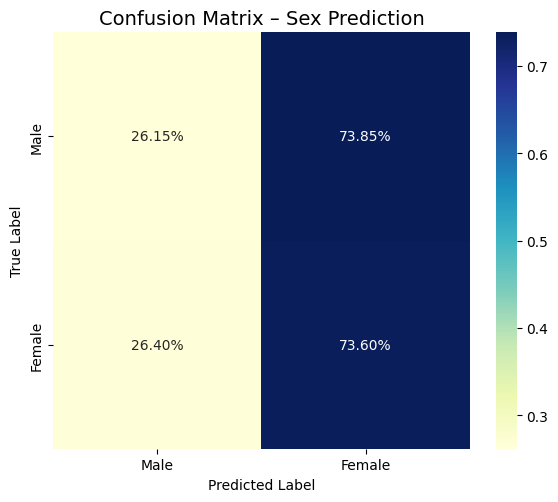

precision (non-adhd): 0.265625
recall (non-adhd): 0.26153846153846155
precision (adhd): 0.7318435754189944
recall (adhd): 0.7359550561797753


In [19]:
# -----------------------
# 1. implement class weighting in loss
# -----------------------

# calculate ratio of adhd vs non-adhd to balance the loss function
female_ratio = (labels_diagnosis == 1).float().mean().item()
male_ratio = 1.0 - female_ratio

# set pos_weight to give more attention to the non-adhd class
pos_weight = torch.tensor(male_ratio / female_ratio)

# use binary cross entropy with logits and class weights
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)


# -----------------------
# 2. update your GCN class with dropout
# -----------------------

# inside your GCN class definition, make sure you add this to __init__:
# self.dropout = torch.nn.Dropout(0.3)

# then in the forward method, apply dropout after final conv like this:
# x5 = self.dropout(self.conv5(x4, edge_index) + x4)


# -----------------------
# 3. define a helper to compute validation loss
# -----------------------

def evaluate_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in data_loader:
            data.to(device)
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(data_loader)


# -----------------------
# 4. early stopping during training
# -----------------------

# number of training epochs
num_epochs = 50  # set how long you want to train for

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train(train_loader)
    val_loss = evaluate_loss(model, val_loader)

    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"early stopping at epoch {epoch}")
            break

# restore best model
model.load_state_dict(best_model_state)

# -----------------------
# 5. evaluate test set predictions and per-class metrics
# -----------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# define test_loader
test_loader = DataLoader(X_test, batch_size=8, shuffle=False)

# run model predictions
y_true, y_pred, y_probs = evaluate_model(model, test_loader)

# compute metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Test Accuracy:", round(acc, 3))
print("Test F1 Score:", round(f1, 3))
print("Precision:", round(precision, 3))
print("Recall:", round(recall, 3))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))

# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu", fmt=".2%", square=True, cbar=True)
plt.title("Confusion Matrix – Sex Prediction", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5], ["Male", "Female"])
plt.yticks([0.5, 1.5], ["Male", "Female"])
plt.tight_layout()
plt.show()

# -----------------------
# 6. evaluate class-wise precision and recall
# -----------------------

print("precision (non-adhd):", precision_score(y_true, y_pred, pos_label=0))
print("recall (non-adhd):", recall_score(y_true, y_pred, pos_label=0))
print("precision (adhd):", precision_score(y_true, y_pred, pos_label=1))
print("recall (adhd):", recall_score(y_true, y_pred, pos_label=1))


# Summary of Findings (Part 2 – GNN Refinements and Sex Prediction)
For ADHD diagnosis, the final test F1 score was approximately 0.68, with stronger performance on ADHD cases than non-ADHD. For sex prediction, the test F1 score was 0.73, with room for improvement in male classification. 

## i. What worked best and why?

A custom Graph Neural Network model using EdgeConv layers performed reasonably well for ADHD diagnosis prediction using fMRI connectome matrices. The GNN architecture included 5 EdgeConv layers with skip connections and a global mean pooling layer. Incorporating top-k strongest node connections effectively converted each subject’s connectome into a sparse graph structure. This format helped the model learn localized functional connectivity patterns that appear meaningful in ADHD prediction. Class weighting and early stopping further improved performance consistency during cross-validation.

In the refinement phase, increasing the graph sparsity (top-k = 15 edges per node) and incorporating early stopping stabilized the training and slightly improved macro F1 performance. Class weighting in the loss function helped reduce the performance gap between ADHD and non-ADHD classes, especially improving recall for the underrepresented class. Dropout added after the last convolution layer also helped reduce overfitting in earlier epochs. 

Additionally, for training, changing the top-k indices to take the absolute values of the connections made the accuracy better.

## ii. What didn't help
Initially, using raw matrices without pruning to top-k edges caused overfitting and poor generalization. The model also suffered from significant class imbalance until RandomOverSampler was applied during training. Even after adjustments, recall and precision were significantly lower for the non-ADHD class, indicating the GNN still struggles with identifying true negatives. Attempts to add dropout showed marginal benefits and led to higher variance across folds without consistent gain on the test set.

Despite refinements, the GNN continued to struggle with low precision on non-ADHD cases. Dropout regularization slightly improved generalization but also introduced higher fold-to-fold variance. For sex prediction, the model still exhibited strong bias toward the majority class (female), and early stopping triggered very quickly, suggesting poor loss convergence. Using the same architecture for both tasks without task-specific tuning may have limited the performance on the second task. Also, taking the absolute values also did not improve the accuracy scores on the test data set.  

## iii. What model will you likely submit for final report?

The XGNN combined method will be the model to submit for the final report. It will be based on the updated GNN model with:

• Top-15 sparsified graph construction
• Class-balanced loss functions for both ADHD and sex prediction
• Dropout regularization and early stopping to avoid overfitting
• EdgeConv architecture with skip connections and global mean pooling